In [3]:
import pandas as pd
import numpy as np


dane = pd.read_excel("loty_clean.xlsx")

from sklearn.model_selection import train_test_split
dane = dane.rename(columns={"#Layovers": "Num_Layovers", "Price [PLN]": "Price"})
dane["Flight_date"] = pd.to_datetime(dane["Flight_date"])
dane["Extraction_Time"] = pd.to_datetime(dane["Extraction_Time"].str.split(" ").apply(lambda x: x[0]), dayfirst=True)
dane.drop(columns = ["Extraction_Time", "Flight_date", "arr_city", "dep_city",
                     "Departure_airport_name", "Destination_airport_name",
                     "layover_airport", "ujemne", "low_cost1", "low_cost2"], inplace=True)
dane.drop(columns=[
    "Ticket_class", "Departure_airport_code", "Destination_airport_code",
    "Flight_weekday", "Extraction_Weekday", "Airline1", "Airline2", "Is_-2"
], inplace=True, errors='ignore')

# przekształcamy na numeryczne (na wszelki wypadek)
dane = dane.apply(pd.to_numeric)

# target variable - cena lotu (zł)
X = dane.drop(columns="Price")
y = dane["Price"]
import random

random.seed(123)  # ziarenko dla powtarzalności wyników

# podział na zbiór treningowy, walidacyjny i testowy - proporcje 80% : 20% : 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# konwersja do macierzy numpy
X_train_np = X_train.to_numpy().astype(np.float64)
y_train_np = y_train.to_numpy().astype(np.float64)
X_test_np = X_test.to_numpy().astype(np.float64)
y_test_np = y_test.to_numpy().astype(np.float64)

In [4]:
import pandas as pd
import numpy as np
import time
from glob import glob
from rf_regressor import RandomForestRegressor, mean_absolute_error, mean_squared_error, \
    r2_score, mean_absolute_percentage_error

# === Output filename ===
files = glob("feature_test_*.xlsx")
filename = f"feature_test_{len(files)+1}.xlsx"

# List to store results
feature_removal_results = []

# Get feature names
feature_names = list(X_train.columns)

print("🔎 Starting feature importance test by removing each feature...")

for feature_to_remove in feature_names:
    print(f"\n🚫 Removing feature: {feature_to_remove}")

    # Drop one feature
    X_train_sub = X_train.drop(columns=[feature_to_remove])
    X_test_sub = X_test.drop(columns=[feature_to_remove])

    # Convert to NumPy
    X_train_np = X_train_sub.to_numpy()
    X_test_np = X_test_sub.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()

    # Adjust max_features
    max_features = int(X_train_np.shape[1] / 3)

    # Train the model
    rf = RandomForestRegressor(
        n_estimators=50,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=max_features,
        bootstrap=True,
        random_state=42
    )

    start_time = time.time()
    rf.fit(X_train_np, y_train_np)
    train_time = time.time() - start_time

    # Make predictions
    pred_train = rf.predict(X_train_np)
    pred_test = rf.predict(X_test_np)

    # Metrics
    result = {
        "feature_removed": feature_to_remove,
        "train_MSE": mean_squared_error(y_train_np, pred_train),
        "test_MSE": mean_squared_error(y_test_np, pred_test),
        "test_R2": r2_score(y_test_np, pred_test),
        "test_MAE": mean_absolute_error(y_test_np, pred_test),
        "test_MAPE": mean_absolute_percentage_error(y_test_np, pred_test),
        "train_time_sec": train_time
    }

    if rf.bootstrap:
        result["OOB_R2"] = rf.oob_score_
        result["OOB_MSE"] = rf.oob_mse_

    feature_removal_results.append(result)

# Save results
result_df = pd.DataFrame(feature_removal_results)
result_df.to_excel(filename, index=False)
print(f"\n✅ Feature removal test completed. Results saved to: {filename}")


🔎 Starting feature importance test by removing each feature...

🚫 Removing feature: Departure_time

🚫 Removing feature: Arrival_time

🚫 Removing feature: Flight_time

🚫 Removing feature: Num_Layovers

🚫 Removing feature: Cabin_bag

🚫 Removing feature: Checked_bag

🚫 Removing feature: Days_to_departure

🚫 Removing feature: layover_duration

✅ Feature removal test completed. Results saved to: feature_test_1.xlsx


Quick MSE test — does performance improve as trees increase?

n_estimators =   1 | Test MSE = 654845.2057
n_estimators =   5 | Test MSE = 193920.6117
n_estimators =  10 | Test MSE = 168710.1031
n_estimators =  20 | Test MSE = 164369.9255
n_estimators =  30 | Test MSE = 175483.3243
n_estimators =  50 | Test MSE = 176940.6282
n_estimators = 100 | Test MSE = 167733.9768


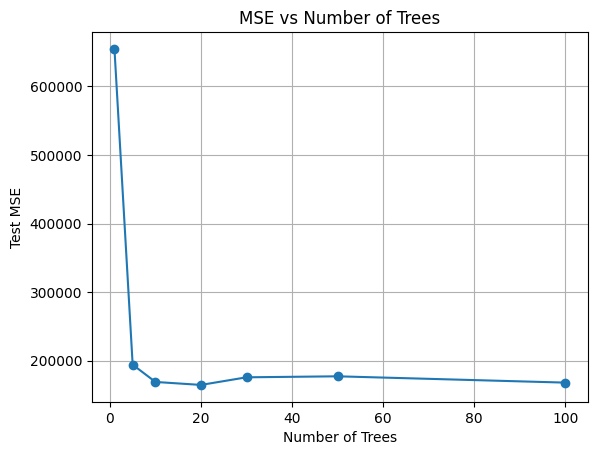

In [7]:
#test tylko do mse xd


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rf_regressor import RandomForestRegressor, mean_squared_error

# === Load and prepare your dataset ===
dane = dane.apply(pd.to_numeric)

# target variable - cena lotu (zł)
X = dane.drop(columns="Price")
y = dane["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()



# === Quick MSE test for different number of trees ===
n_trees_list = [1, 5, 10, 20, 30, 50, 100]
mse_list = []

print("Quick MSE test — does performance improve as trees increase?\n")

for n_trees in n_trees_list:
    rf = RandomForestRegressor(n_estimators=n_trees, max_depth=5, max_features='sqrt', bootstrap=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    print(f"n_estimators = {n_trees:3} | Test MSE = {mse:.4f}")

# === Optional: Plot ===
plt.plot(n_trees_list, mse_list, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Test MSE")
plt.title("MSE vs Number of Trees")
plt.grid(True)
plt.show()

